# Disaster tweet Project

Analysis disaster tweet for Jedha certification. #block4

In [2]:
# import
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from module import helper
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import layers
import keras_tuner as kt
from keras.models import Sequential, Model
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

from keras.layers import *
from keras.callbacks import *

import transformers
from transformers import AutoConfig, AutoModel
from transformers import AutoTokenizer, TFAutoModel

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import re
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer,PorterStemmer,LancasterStemmer

from wordcloud import WordCloud,STOPWORDS
from IPython.display import HTML, display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import plotly
import cufflinks
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

plotly.offline.init_notebook_mode(connected=True)
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

import warnings
from string import punctuation
from collections import defaultdict
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# sns 
color_palette = ['#265952', '#DFCEEB', '#DBDE2F', '#45201E', '#c7ac92', '#a44a3f']
sns.set_palette(sns.color_palette(color_palette))

## Load data

In [4]:
# dataset csv
train_csv = "../data/raw/train.csv"
test_csv = "../data/raw/test.csv"

# dataframes
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# display train
print("Train dataset")
display(train_df.sample(1))

# display test
print("Test dataset")
display(test_df.sample(1))

Train dataset


,id,keyword,location,text,target
5588,7973,razed,NaN,The Latest: More Homes Razed by Northern Calif...,1


Test dataset


,id,keyword,location,text
1243,4075,displaced,usa,local family displaced by fire http://t.co/f1n...


## EDA

In [5]:
## dataframe
disaster_df = train_df[["text", "target"]].copy()

#### Basic statistics

In [6]:
helper.general_statistics(disaster_df)

Number of rows : 7613

Display of dataset: 


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1



Basics statistics: 


,text,target
count,7613,7613.00000
unique,7503,NaN
top,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,10,NaN
mean,NaN,0.42966
std,NaN,0.49506
min,NaN,0.00000
25%,NaN,0.00000
50%,NaN,0.00000
75%,NaN,1.00000



General information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


None


Percentage of missing values: 


text      0.0
target    0.0
dtype: float64

In [7]:
disaster_df

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


#### Analysis

<Figure size 720x504 with 0 Axes>

Text(0.5, 1.0, 'Counts for disasters and non disasters tweets')

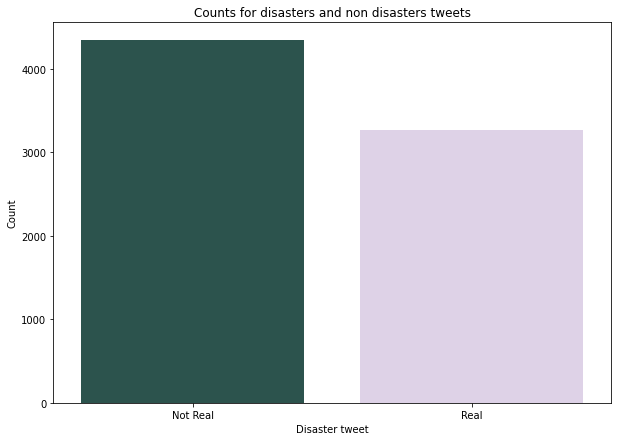

In [8]:
# number of plot
disaster_count_df = pd.DataFrame(disaster_df.groupby(["target"]).size()).reset_index()
disaster_count_df = disaster_count_df.rename(columns={0: "Count", 
                                            "target" : "Disaster tweet"})
disaster_count_df["Disaster tweet"] = disaster_count_df["Disaster tweet"].apply(lambda x : "Real" if x==1 else "Not Real")

# bar plot by conversion class
plt.figure(figsize=(10,7))
ax = sns.barplot(x="Disaster tweet", y="Count", data=disaster_count_df);
plt.title("Counts for disasters and non disasters tweets")
plt.show()

In [9]:
# stop words in dataset
## corpus : collection of texts
def create_corpus(df, target):
    """ create corpus.
    """
    corpus = []
    for i in df[df['target']==target]['text'].str.split():
        for x in i:
            corpus.append(x)
    return corpus

## stop words : most common words in a language.
def count_stopwords(df, func, target):
    """ analyse stop words.
    """
    df_stopwords = pd.DataFrame(columns=["stop_words", "count"])

    corpus = func(df, target)
    dic = defaultdict(int)

    for word in corpus:
        dic[word] += 1

    top = sorted(dic.items(), key = lambda x: x[1], reverse=True)[:10]
    x_items,y_values = zip(*top)

    # fill dataframe
    df_stopwords["stop_words"] = x_items
    df_stopwords["count"] = y_values
    
    # sort values
    df_stopwords = df_stopwords.sort_values(by=["count"])

    return df_stopwords

#analyzing stopwords for 0 and 1 target labels
df_stopwords_0 = count_stopwords(disaster_df, create_corpus, 0)
print("Stop words for Non disaster target")
display(df_stopwords_0)

df_stopwords_1 = count_stopwords(disaster_df, create_corpus, 1)
print("Stop words for disaster target")
display(df_stopwords_1)

Stop words for Non disaster target


,stop_words,count
9,for,452
8,is,512
7,you,529
6,in,720
5,of,834
4,and,840
3,I,938
2,to,1099
1,a,1115
0,the,1524


Stop words for disaster target


,stop_words,count
9,is,302
8,for,368
7,on,386
6,-,389
5,and,462
4,to,706
3,a,730
2,of,888
1,in,1037
0,the,1051


<Figure size 504x360 with 0 Axes>

Text(0.5, 1.0, 'Top stop words in non disaster tweet.')

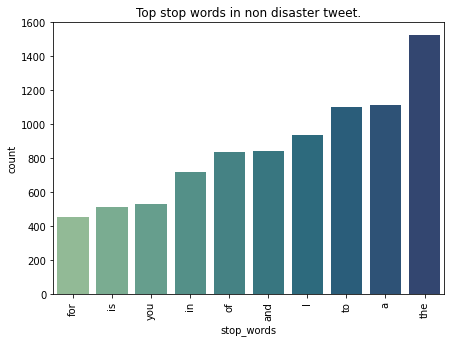

In [10]:
# graph
plt.figure(figsize=(7,5))
ax1 = sns.barplot(x="stop_words", y="count", data=df_stopwords_0, palette="crest");
ax1.tick_params(axis='x', rotation=90)
plt.title("Top stop words in non disaster tweet.")
plt.show()

<Figure size 504x360 with 0 Axes>

Text(0.5, 1.0, 'Top stop words in disaster tweet.')

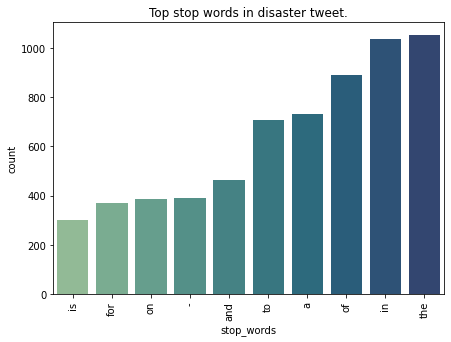

In [11]:
plt.figure(figsize=(7,5))
ax2 = sns.barplot(x="stop_words", y="count", data=df_stopwords_1, palette="crest");
ax2.tick_params(axis='x', rotation=90)
plt.title("Top stop words in disaster tweet.")
plt.show()

#### Unwanted words
Remove unwanted words with high frequency.

In [12]:
common_words = ['via','like','build','get','would','one','two','feel',
                'lol','fuck','take','way','may','first','latest','want',
                'make','back','see','know','let','look','come','got',
                'still','say','think','great','pleas','amp']

def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)

disaster_df["Cleaned_text"] = disaster_df["text"].apply(text_cleaning)

#### Lemmatizing
What is lemmatizing?  
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. 

#### Word cloud

In [13]:
# word cloud
def wordcloud(df, column, title):
    words = ' '.join(df[column].astype('str').tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords=stopwords, width=512, height=512).generate(words)
    plt.figure(figsize=(10,8), frameon=True)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

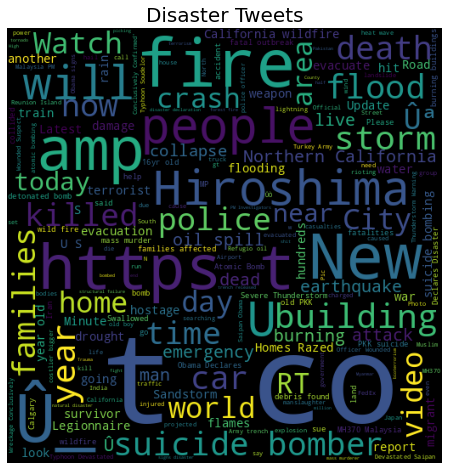

In [14]:
# common words in disaster tweets
wordcloud(disaster_df[disaster_df["target"]==1], "Cleaned_text", "Disaster Tweets")

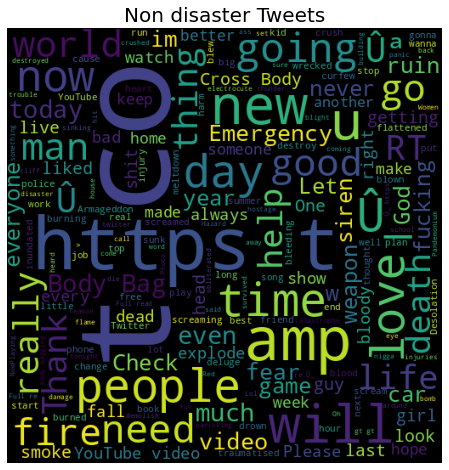

In [15]:
# common words in non disaster tweets
wordcloud(disaster_df[disaster_df["target"]==0], "Cleaned_text", "Non disaster Tweets")

#### 10 N-grams 
They are basically a set of co-occurring words within a given window and when computing the n-grams you typically move one word forward.

In [16]:
# helper functions : n-grams
def top_ngrams(df, N, grams):
    count_vec = CountVectorizer(ngram_range=(grams,grams)).fit(df)
    bow = count_vec.transform(df)

    add_words = bow.sum(axis=0)
    word_freq = [(word, add_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True) 
    return word_freq[:N]

In [17]:
common_uni = top_ngrams(disaster_df["Cleaned_text"],10,1)
common_bi = top_ngrams(disaster_df["Cleaned_text"],10,2)
common_tri = top_ngrams(disaster_df["Cleaned_text"],10,3)
common_uni_df = pd.DataFrame(common_uni,columns=['word','freq'])
common_bi_df = pd.DataFrame(common_bi,columns=['word','freq'])
common_tri_df = pd.DataFrame(common_tri,columns=['word','freq'])

In [18]:
common_tri_df

,word,freq
0,û_ http co,217
1,liked youtube video,42
2,video http co,42
3,û_ https co,35
4,northern california wildfire,29
5,more homes razed,29
6,homes razed by,29
7,2015 http co,28
8,the latest more,28
9,latest more homes,28


## Preprocessing

### NLP Preprocessing

#### Split

In [19]:
# split feature, target 
X_inp_clean = disaster_df['Cleaned_text']
X_inp_original = disaster_df['text']
y_inp = disaster_df['target']

#### Tokenization
Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens. 

In [20]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_inp_clean.values)
vocab_length = len(word_tokenizer.word_index) + 1

In [21]:
# Creating padded sentences using pad_sequences()
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(X_inp_clean.values, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(X_inp_clean.values), 
                                 length_long_sentence, padding='post')

In [22]:
padded_sentences

array([[ 107, 4632,   24, ...,    0,    0,    0],
       [ 168,   44,  205, ...,    0,    0,    0],
       [  39, 1748, 1616, ...,    0,    0,    0],
       ...,
       [2822, 2398,  691, ...,    0,    0,    0],
       [  74, 1137,   40, ...,    0,    0,    0],
       [   4,  355,   51, ...,    0,    0,    0]], dtype=int32)

#### Embedding matrix
Creating Embedding dictionary using [Glove Twitter data].
Link : (https://www.kaggle.com/danielwillgeorge/glove6b100dtxt)

In [23]:
# use glove twitter data
embeddings_dictionary = dict()
embedding_dim = 100

glove_file = open('../data/raw/glove.6B.100d.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

# creating Word Embedding matrix
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Sklearn preprocessing

#### Train, val split dataset

In [24]:
# train, val split dataset
X_train, X_val, y_train, y_val = train_test_split(padded_sentences,
                                                  y_inp.values,test_size=0.2,random_state=1)

## Modelling

### CNN Model

In [25]:
# neural network architecture
def CNN(hp):
    
    model = keras.Sequential()
    
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-2, 3e-3, 3e-4, 3e-5])
    
    model.add(Embedding(vocab_length, 100, weights=[embedding_matrix],
                                    input_length=length_long_sentence,trainable=False))
    
    model.add(Conv1D(filters=hp.Int('conv_1_filter',min_value=21,max_value=200,step=14),
                                kernel_size=hp.Choice('conv_1_kernel',values=[3,4,5]),
                                activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())

    model.add(Dense(units = hp.Int('dense_1',min_value=21,max_value=150,step=14),
                                    activation='relu'))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

In [26]:
# train & hyperparameters tuners
tuner_CNN = kt.Hyperband(CNN,
                        objective='val_accuracy',
                        max_epochs=15, 
                        factor=5,
                        directory='hyperband',
                        project_name='DisasterTweets_kt',
                        overwrite=True)

2022-01-18 09:07:56.361364: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
# choose best model
stop_early = EarlyStopping(monitor='val_loss', 
                            mode='min',
                            verbose=1, 
                            patience=10)

tuner_CNN.search(X_train, y_train, epochs=15,
                validation_data=(X_val,y_val),
                callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_CNN=tuner_CNN.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 00m 59s]
val_accuracy: 0.8023637533187866

Best val_accuracy So Far: 0.8089297413825989
Total elapsed time: 00h 09m 20s
INFO:tensorflow:Oracle triggered exit


In [28]:
model_CNN = tuner_CNN.hypermodel.build(best_hps_CNN)

checkpoint = ModelCheckpoint(
    'model_CNN.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)

history_CNN = model_CNN.fit(X_train, y_train, epochs=50,
                            validation_data=(X_val,y_val),
                            callbacks=[checkpoint,stop_early])

Epoch 1/50
190/191 [============================>.] - ETA: 0s - loss: 0.6089 - accuracy: 0.6729
Epoch 00001: val_loss improved from inf to 0.50241, saving model to model_CNN.h5
191/191 [==============================] - 3s 10ms/step - loss: 0.6087 - accuracy: 0.6731 - val_loss: 0.5024 - val_accuracy: 0.7715
Epoch 2/50
185/191 [============================>.] - ETA: 0s - loss: 0.4842 - accuracy: 0.7764
Epoch 00002: val_loss improved from 0.50241 to 0.46515, saving model to model_CNN.h5
191/191 [==============================] - 2s 9ms/step - loss: 0.4855 - accuracy: 0.7759 - val_loss: 0.4652 - val_accuracy: 0.7873
Epoch 3/50
191/191 [==============================] - ETA: 0s - loss: 0.4526 - accuracy: 0.7957
Epoch 00003: val_loss improved from 0.46515 to 0.45674, saving model to model_CNN.h5
191/191 [==============================] - 2s 9ms/step - loss: 0.4526 - accuracy: 0.7957 - val_loss: 0.4567 - val_accuracy: 0.8037
Epoch 4/50
185/191 [============================>.] - ETA: 0s - los

In [29]:
# model summary
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 71, 100)           2270100   
                                                                 
 conv1d_1 (Conv1D)           (None, 69, 35)            10535     
                                                                 
 dropout_2 (Dropout)         (None, 69, 35)            0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 34, 35)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1190)              0         
                                                                 
 dense_2 (Dense)             (None, 147)               175077    
                                                      

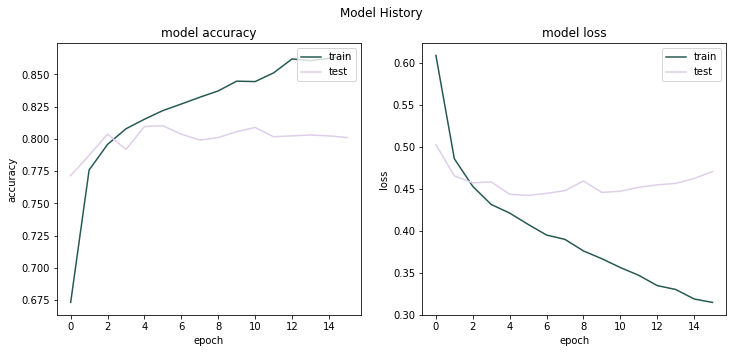

In [30]:
# model_history()
def model_history(model_history):
    fig,(ax1,ax2) =  plt.subplots(1,2,figsize=(12,5))
    
    # summarize history for accuracy
    ax1.plot(model_history.history['accuracy'])
    ax1.plot(model_history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='upper right')

    # summarize history for loss
    ax2.plot(model_history.history['loss'])
    ax2.plot(model_history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper right')
    
    fig.suptitle("Model History")

# model history
model_history(history_CNN)